<a href="https://colab.research.google.com/github/HanifFaishalH/Kuis2_KlasifikasiJenisBatik/blob/main/Kuis2_Batik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# 1. Preprocessing Data Batik

augmentasi data > 1 gambar menjadi 4 gambar (1 gambar asli + 3 gambar hasil augmentasi)
Image enhancement → contras/brightness correction, noise removal, glare removal, etc.

In [ ]:
!pip install albumentations==1.3.1 opencv-python tqdm

import cv2
import numpy as np
import albumentations as A
from pathlib import Path
from google.colab import files
from tqdm import tqdm

input_folder = ('/content/drive/MyDrive/batik_dataset/Batik300')
output_folder = ('/content/drive/MyDrive/batik_dataset/batik_aug')
copies_per_image = 3
img_size = 512

Path(output_folder).mkdir(parents=True, exist_ok=True)

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomRotate90(p=0.7),
    A.Rotate(limit=30, p=0.5),
])

image_files = sorted([
    p for p in Path(input_folder).glob("*")
    if p.suffix.lower() in [".jpg", ".jpeg", ".png"]
])

print(f"Total gambar batik-cap ditemukan: {len(image_files)}")
print(f"Memulai augmentasi (Total output: {len(image_files) * (copies_per_image + 1)} gambar)...")

for img_path in tqdm(image_files, desc="Augmentasi Gambar"):
    img = cv2.imread(str(img_path))
    if img is None:
        print(f"Gagal membaca: {img_path.name}, skipping.")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    base_name = img_path.stem

    original_resized = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)
    save_path_original = Path(output_folder) / f"{base_name}_original.jpg"
    cv2.imwrite(str(save_path_original), cv2.cvtColor(original_resized, cv2.COLOR_RGB2BGR))

    for i in range(copies_per_image):
        aug = transform(image=img)
        aug_img = aug["image"]

        if aug_img.dtype != np.uint8:
            aug_img = np.clip(aug_img, 0, 255).astype(np.uint8)

        aug_img = cv2.resize(aug_img, (img_size, img_size), interpolation=cv2.INTER_AREA)

        save_path = Path(output_folder) / f"{base_name}_aug_{i+1:02d}.jpg"
        cv2.imwrite(str(save_path), cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))

print("\nSelesai! Semua gambar batik-cap berhasil di-augment.")
print(f"Total gambar di folder output: {len(list(Path(output_folder).glob('*.jpg')))}")

Total gambar batik-cap ditemukan: 300
Memulai augmentasi (Total output: 1200 gambar)...


Augmentasi Gambar: 100%|██████████| 300/300 [00:26<00:00, 11.50it/s]



Selesai! Semua gambar batik-cap berhasil di-augment.
Total gambar di folder output: 1200


Melakukan enhancement gambar...


100%|██████████| 4800/4800 [44:58<00:00,  1.78it/s]


Enhancement selesai! Hasil disimpan di: /content/drive/MyDrive/Colab Notebooks/Pembelarajan Mesin/Minggu 12/batik-enhanced


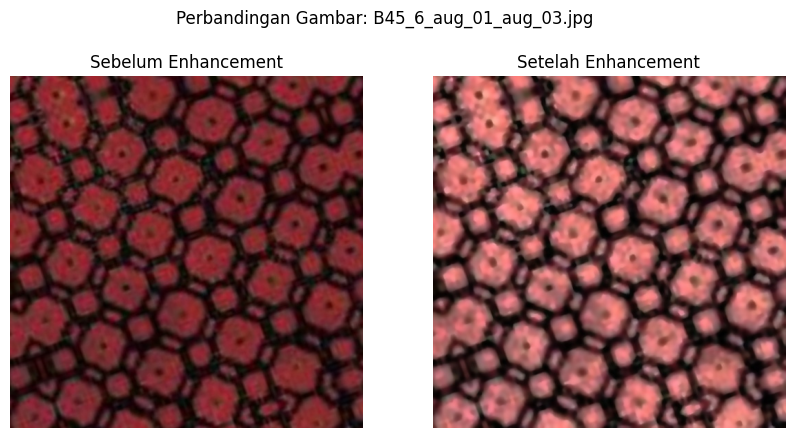

In [ ]:
import cv2
import os
import numpy as np
from tqdm import tqdm
import random
from matplotlib import pyplot as plt

input_dir = '/content/drive/MyDrive/batik_dataset/batik_aug'
output_dir = '/content/drive/MyDrive/batik_dataset/batik-enhanced'
os.makedirs(output_dir, exist_ok=True)

def enhance_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None

    # 1. Contrast enhancement (CLAHE)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    enhanced = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    # 2. Brightness normalization
    hsv = cv2.cvtColor(enhanced, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.equalizeHist(v)
    hsv_enhanced = cv2.merge((h, s, v))
    enhanced = cv2.cvtColor(hsv_enhanced, cv2.COLOR_HSV2BGR)

    # 3. Noise removal (bilateral)
    denoised = cv2.bilateralFilter(enhanced, d=9, sigmaColor=75, sigmaSpace=75)

    # 4. Glare removal
    gray = cv2.cvtColor(denoised, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
    glare_removed = cv2.inpaint(denoised, mask, 3, cv2.INPAINT_TELEA)

    return glare_removed

print("Melakukan enhancement gambar...")
for filename in tqdm(os.listdir(input_dir)):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)
        enhanced = enhance_image(input_path)
        if enhanced is not None:
            cv2.imwrite(output_path, enhanced)
print("Enhancement selesai! Hasil disimpan di:", output_dir)

# === Tampilkan 1 gambar random sebelum dan sesudah enhancement ===
random_file = random.choice([f for f in os.listdir(input_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
before_path = os.path.join(input_dir, random_file)
after_path = os.path.join(output_dir, random_file)

before = cv2.imread(before_path)
after = cv2.imread(after_path)

# Ubah BGR ke RGB agar warna tampil benar di matplotlib
before = cv2.cvtColor(before, cv2.COLOR_BGR2RGB)
after = cv2.cvtColor(after, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(before)
plt.title("Sebelum Enhancement")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(after)
plt.title("Setelah Enhancement")
plt.axis("off")

plt.suptitle(f"Perbandingan Gambar: {random_file}")
plt.show()

# 2. Ekstraksi Fitur

Metode ekstraksi fitur yang digunakan terdiri dari tiga jenis, yaitu GLCM, LBP, dan HSV Histogram. Fitur ini diekstraksi dari setiap gambar batik untuk membedakan motif batik (misal parang, kawung, mega mendung, dsb.):

GLCM (Gray Level Co-occurrence Matrix) – menangkap tekstur motif, seperti rapat atau halus, melalui fitur contrast, dissimilarity, homogeneity, energy, correlation.

LBP (Local Binary Pattern) – menangkap pola lokal pada motif, misal garis, titik, atau pola berulang, menggunakan mean dan std histogram LBP.

HSV Histogram – menangkap ciri warna motif, seperti dominasi warna atau gradasi khas motif batik.

In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
import re
from tqdm import tqdm
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern

# === Path input dan output ===
input_dir = '/content/drive/MyDrive/batik_dataset/batik-enhanced'  # folder hasil enhancement
label_csv = '/content/drive/MyDrive/batik_dataset/motif_batik_label.csv'
output_csv = '/content/drive/MyDrive/batik_dataset/batik_motif_features.csv'

# === Fungsi ekstraksi fitur citra ===
def extract_features(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # --- GLCM ---
    glcm = graycomatrix(gray, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast').mean()
    dissimilarity = graycoprops(glcm, 'dissimilarity').mean()
    homogeneity = graycoprops(glcm, 'homogeneity').mean()
    energy = graycoprops(glcm, 'energy').mean()
    correlation = graycoprops(glcm, 'correlation').mean()

    # --- LBP ---
    lbp = local_binary_pattern(gray, 8, 1, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 59))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    lbp_mean = hist.mean()
    lbp_std = hist.std()

    # --- HSV ---
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist_h = cv2.calcHist([hsv], [0], None, [8], [0, 180])
    hist_s = cv2.calcHist([hsv], [1], None, [8], [0, 256])
    hist_v = cv2.calcHist([hsv], [2], None, [8], [0, 256])
    color_features = np.concatenate([hist_h, hist_s, hist_v]).flatten()
    color_features /= (color_features.sum() + 1e-7)

    return np.hstack([
        [contrast, dissimilarity, homogeneity, energy, correlation],
        [lbp_mean, lbp_std],
        color_features
    ])

# === Ekstraksi fitur dari semua gambar ===
data = []
filenames = []

print("Mengekstraksi fitur dari semua citra di folder...")
for file in tqdm(os.listdir(input_dir)):
    if file.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(input_dir, file)
        feats = extract_features(img_path)
        if feats is not None:
            data.append(feats)
            filenames.append(file)

# === Jika tidak ada citra valid ===
if len(data) == 0:
    print("Tidak ada citra valid di folder ini! Pastikan input_dir sudah benar.")
else:
    # === Buat DataFrame fitur ===
    columns = [
        'contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation',
        'lbp_mean', 'lbp_std'
    ] + [f'color_{i+1}' for i in range(24)]

    features_df = pd.DataFrame(data, columns=columns)
    features_df['filename'] = filenames

    # === Baca file label hasil deteksi motif ===
    labels_df = pd.read_csv(label_csv)

    # === Fungsi normalisasi nama file ===
    def normalize_filename(name):
        """
        Normalisasi nama file dengan mengekstrak hanya ID Kelas utamanya.
        Contoh:
        - 'B10_2_original.jpg'  -> 'B10'
        - 'B10_1.jpg'           -> 'B10'
        - 'B23_1.jpg'           -> 'B23'
        """
        match = re.match(r'(B\d+)', name, flags=re.IGNORECASE)
        if match:
            return match.group(1)
        return name

    # === Normalisasi nama di kedua dataset ===
    features_df['base_name'] = features_df['filename'].apply(normalize_filename)
    labels_df['base_name'] = labels_df['filename'].apply(normalize_filename)

    # === Debug: tampilkan contoh perbandingan nama ===
    print("\n Contoh nama setelah normalisasi:")
    print("Fitur :", features_df['base_name'].unique()[:5])
    print("Label :", labels_df['base_name'].unique()[:5])

    # === Merge label ke fitur ===
    merged_df = features_df.merge(labels_df[['base_name', 'motif_batik']],
                                  on='base_name', how='left')
    merged_df.rename(columns={'motif_batik': 'motif_name'}, inplace=True)
    merged_df.drop(columns=['base_name'], inplace=True)

    # === Cek data tanpa label ===
    missing_before = merged_df['motif_name'].isna().sum()
    print(f"\n Ada {missing_before} citra tanpa motif_name sebelum perbaikan.")

    # === Fungsi fallback aman untuk isi label yang hilang ===
    def fill_label_safe(row):
        # Jika sudah ada label, kembalikan langsung
        if pd.notna(row['motif_name']):
            return row['motif_name']

        fname = row['filename']
        m = re.match(r'(B\d+_\d+)', fname)
        if not m:
            return np.nan
        key = m.group(1)

        # Coba beberapa strategi pencocokan
        for method, func in [
            ('exact', labels_df['base_name'] == key),
            ('startswith', labels_df['base_name'].str.startswith(key, na=False)),
            ('contains', labels_df['base_name'].str.contains(key, case=False, na=False))
        ]:
            cand = labels_df.loc[func, 'motif_batik']
            if not cand.empty:
                return cand.iloc[0]

        return np.nan  # jika gagal ditemukan

    # Terapkan hanya pada baris yang belum punya label
    merged_df['motif_name'] = merged_df.apply(fill_label_safe, axis=1)

    # === Cek hasil akhir ===
    missing_after = merged_df['motif_name'].isna().sum()
    print(f" Label berhasil diisi. Sebelum: {missing_before} | Sekarang: {missing_after}")

    # Tampilkan contoh jika masih ada yang kosong
    if missing_after > 0:
        print("\nContoh file tanpa label (cek manual):")
        display(merged_df[merged_df['motif_name'].isna()][['filename']].head(10))

    # === Simpan hasil ke CSV ===
    merged_df.to_csv(output_csv, index=False)
    print(f"\n Ekstraksi dan labeling selesai!")
    print(f" File disimpan di: {output_csv}")
    print(f" Total citra: {len(merged_df)} | Tanpa label: {missing_after}")

    # Tampilkan contoh hasil akhir
    display(merged_df[['filename', 'motif_name']].head(10))


Mengekstraksi fitur dari semua citra di folder...


100%|██████████| 1200/1200 [03:30<00:00,  5.69it/s]



 Contoh nama setelah normalisasi:
Fitur : ['B10' 'B11' 'B12' 'B13' 'B14']
Label : ['B1' 'B2' 'B3' 'B4' 'B5']

 Ada 0 citra tanpa motif_name sebelum perbaikan.
 Label berhasil diisi. Sebelum: 0 | Sekarang: 0

 Ekstraksi dan labeling selesai!
 File disimpan di: /content/drive/MyDrive/batik_dataset/batik_motif_features.csv
 Total citra: 1200 | Tanpa label: 0


,filename,motif_name
0,B10_1_original.jpg,Mega Mendung
1,B10_1_aug_01.jpg,Mega Mendung
2,B10_1_aug_02.jpg,Mega Mendung
3,B10_1_aug_03.jpg,Mega Mendung
4,B10_2_original.jpg,Mega Mendung
5,B10_2_aug_01.jpg,Mega Mendung
6,B10_2_aug_02.jpg,Mega Mendung
7,B10_2_aug_03.jpg,Mega Mendung
8,B10_3_original.jpg,Mega Mendung
9,B10_3_aug_01.jpg,Mega Mendung


## Reduksi Dimensi dengan PCA

 Data awal:
      contrast  dissimilarity  homogeneity    energy  correlation  lbp_mean  \
0  1685.210698      18.340142     0.237834  0.015972     0.767955  0.017241   
1   966.878437      13.327604     0.248135  0.016832     0.861494  0.017241   
2  1007.872664      13.747147     0.245647  0.016724     0.855552  0.017241   
3  1685.401400      18.340902     0.238423  0.015964     0.767945  0.017241   
4  1629.724909      18.032017     0.239065  0.016006     0.775064  0.017241   

    lbp_std   color_1   color_2   color_3  ...  color_17  color_18  color_19  \
0  0.042139  0.327084  0.000379  0.000047  ...  0.030233  0.047363  0.046417   
1  0.045330  0.327251  0.000607  0.000089  ...  0.032421  0.046149  0.045500   
2  0.044510  0.327558  0.000502  0.000051  ...  0.031905  0.046710  0.045803   
3  0.042150  0.327047  0.000388  0.000036  ...  0.030187  0.047610  0.046099   
4  0.042390  0.326027  0.000552  0.000041  ...  0.031099  0.047668  0.044601   

   color_20  color_21  color_22 

/tmp/ipython-input-487386393.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_labels))


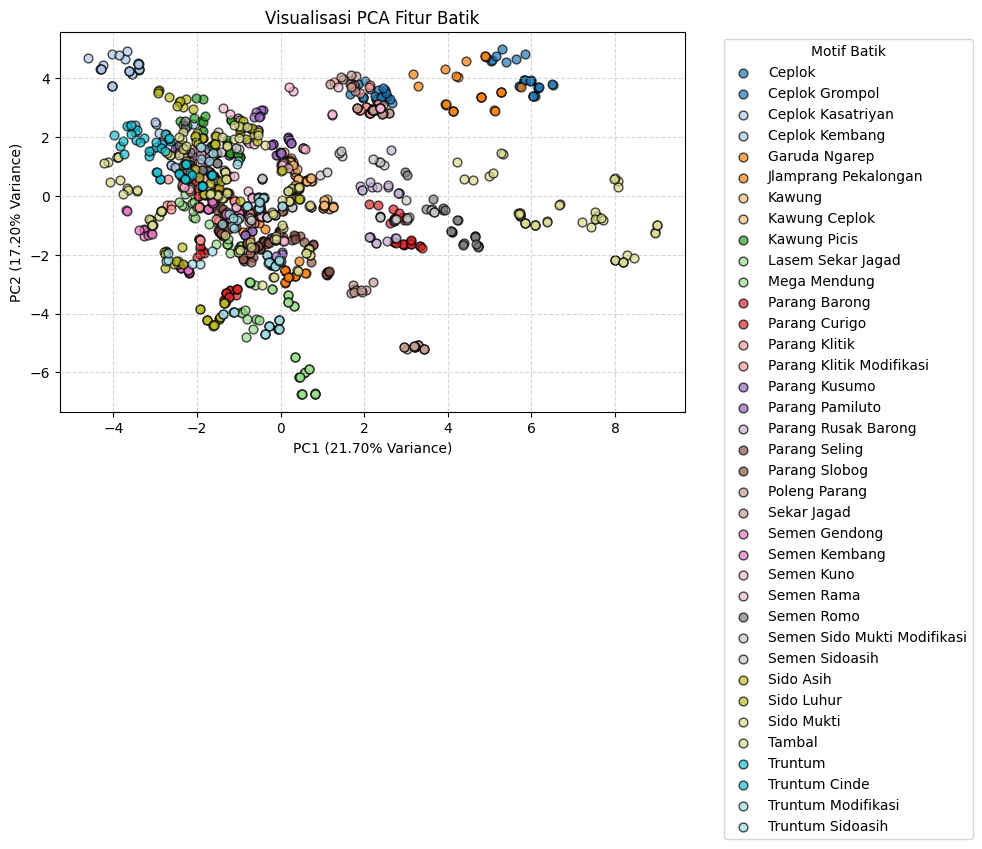

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# === Path file CSV hasil ekstraksi fitur ===
csv_path = '/content/drive/MyDrive/batik_dataset/batik_motif_features.csv'

# === Baca dataset ===
df = pd.read_csv(csv_path)
print(" Data awal:")
print(df.head())

# === Cek missing values ===
missing = df.isnull().sum()
if missing.sum() > 0:
    print("\n Data mengandung nilai kosong, akan diisi dengan rata-rata kolom.")
    df = df.fillna(df.mode(numeric_only=True))
else:
    print("\n Tidak ada nilai kosong.")

# === Pisahkan kolom non-fitur (misalnya filename dan motif_name) ===
non_feature_cols = [col for col in df.columns if not col.startswith((
    'contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'lbp_', 'color_'
))]
print(f"\nKolom non-fitur yang diabaikan: {non_feature_cols}")

# === Ambil fitur numerik untuk PCA ===
X = df.drop(columns=non_feature_cols, errors='ignore')
print(f" Jumlah fitur yang digunakan: {X.shape[1]}")

# === Ambil label (jika ada) ===
y = df['motif_name'] if 'motif_name' in df.columns else None

# === Standarisasi data ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f" Data berhasil distandarisasi. Ukuran: {X_scaled.shape}")

# === PCA untuk reduksi dimensi ===
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("\n Rasio variansi tiap komponen PCA:")
print(f"  PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"  PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")
print(f"  Total variansi dijelaskan: {sum(pca.explained_variance_ratio_)*100:.2f}%")

# === Visualisasi PCA 2D ===
plt.figure(figsize=(10,7))

if y is not None:
    # Filter out NaN values from y before getting unique labels
    valid_y = y.dropna()
    if not valid_y.empty:
        # Jika ada label, beri warna berdasarkan motif_name
        unique_labels = sorted(valid_y.unique())
        colors = plt.cm.get_cmap('tab20', len(unique_labels))

        for i, label in enumerate(unique_labels):
            plt.scatter(
                X_pca[y == label, 0],
                X_pca[y == label, 1],
                color=colors(i),
                label=label,
                alpha=0.7,
                edgecolor='black',
                s=40
            )
        plt.legend(title='Motif Batik', bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        print("\n Tidak ada label motif yang valid untuk divisualisasikan.")
        plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, edgecolor='black', s=40)

else:
    # Jika tidak ada label
    plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, edgecolor='black', s=40)

plt.title('Visualisasi PCA Fitur Batik')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

3. Pembuatan data latih dan data uji
    - Melakukan metode split,
        - 70:30
        - 80:20
        - 90:10
        - Cross-validation dengan k=5

Train-Test Split


=== Hasil Train-Test Split ===
   Split  Train Size  Test Size  SVM_linear  SVM_poly   SVM_rbf  KNN (k=5)  \
0  70:30         840        360         1.0  0.730556  0.997222        1.0   
1  80:20         960        240         1.0  0.729167  0.987500        1.0   
2  90:10        1080        120         1.0  0.775000  1.000000        1.0   

   Naive Bayes  
0     0.897222  
1     0.879167  
2     0.900000  

=== Hasil K-Fold Cross Validation ===
         Model  Mean Accuracy   Std Dev
0   SVM_linear       0.999167  0.001667
1     SVM_poly       0.738333  0.023333
2      SVM_rbf       0.992500  0.009280
3    KNN (k=5)       0.995000  0.003118
4  Naive Bayes       0.887500  0.021246


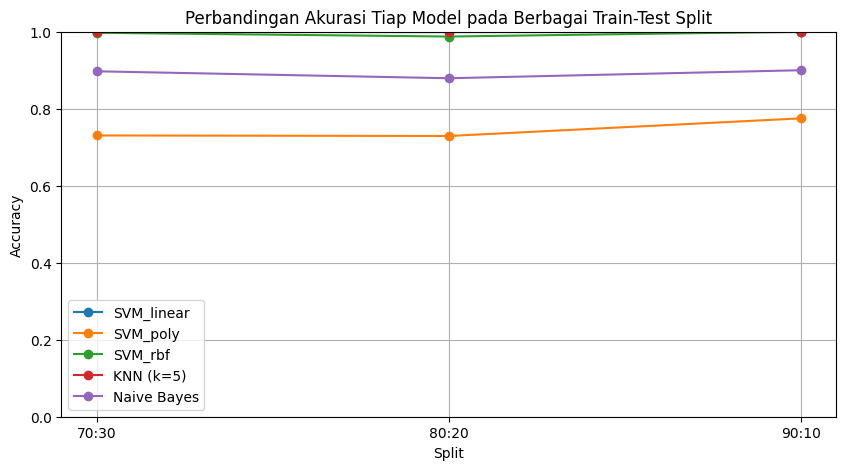

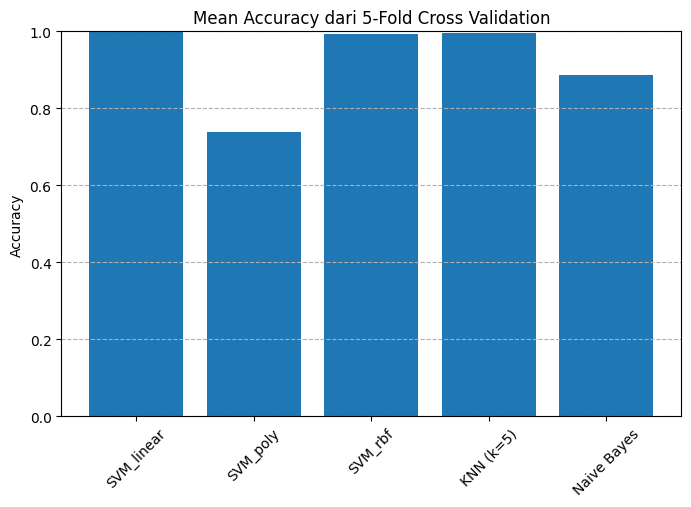

In [ ]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

y = df['motif_name']

models = {
      "SVM_linear": SVC(kernel='linear'),
      "SVM_poly": SVC(kernel='poly'),
      "SVM_rbf": SVC(kernel='rbf'),
      "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
      "Naive Bayes": GaussianNB()
  }

ratios = [0.3, 0.2, 0.1]
ratio_names = ["70:30", "80:20", "90:10"]

results = []
conf_matrices = {}
class_reports = {}

for ratio, split_name in zip(ratios, ratio_names):
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=ratio, random_state=42, stratify=y
    )

    train_size = len(X_train)
    test_size = len(X_test)

    row = [split_name, train_size, test_size]

    for name, m in models.items():
        m.fit(X_train, y_train)
        y_pred = m.predict(X_test)

        # Simpan hasil
        row.append(accuracy_score(y_test, y_pred))

        # Simpan confusion matrix dan classification report
        conf_matrices[(split_name, name)] = confusion_matrix(y_test, y_pred)
        class_reports[(split_name, name)] = classification_report(y_test, y_pred, zero_division=0)

    results.append(row)


# DataFrame hasil utama

res_df = pd.DataFrame(
    results,
    columns=["Split", "Train Size", "Test Size"] + list(models.keys())
)

print("\n=== Hasil Train-Test Split ===")
print(res_df)

# K-Fold Cross Validation

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=kf)
    cv_results.append([name, np.mean(scores), np.std(scores)])

cv_df = pd.DataFrame(cv_results, columns=["Model", "Mean Accuracy", "Std Dev"])

print("\n=== Hasil K-Fold Cross Validation ===")
print(cv_df)

plt.figure(figsize=(10,5))
for model_name in models.keys():
    plt.plot(res_df["Split"], res_df[model_name], marker='o', label=model_name)

plt.title("Perbandingan Akurasi Tiap Model pada Berbagai Train-Test Split")
plt.xlabel("Split")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.bar(cv_df["Model"], cv_df["Mean Accuracy"])
plt.title("Mean Accuracy dari 5-Fold Cross Validation")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--')
plt.show()


# 4. Pembuatan model
    - Model yang digunakan bebas, *kecuali jenis deep learning*
    - Melakukan proses hyperparameter tunning menjadi nilai tambah
    - Simpan model dalam bentuk file


In [ ]:
# === Import library ===
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

# === 1. Baca data fitur hasil ekstraksi ===
csv_path = '/content/drive/MyDrive/batik_dataset/batik_motif_features.csv'
df = pd.read_csv(csv_path)

print("Data tersedia:", df.shape)
print(df[['motif_name']].head())

# === 2. Siapkan fitur dan label ===
X = df[[c for c in df.columns if c.startswith(('contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'lbp_', 'color_'))]]
y = df['motif_name']   # atau bisa 'region' jika ingin klasifikasi berdasarkan daerah

# Encode label jadi angka
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# === 3. Split data (80% train, 20% test) ===
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# === 4. Standarisasi fitur ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === 5. Hyperparameter tuning dengan GridSearchCV (SVM RBF) ===
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf']
}

print("Melakukan GridSearchCV...")
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=1, cv=3, n_jobs=-1)
grid.fit(X_train_scaled, y_train)

print("Best Parameters:", grid.best_params_)
print("Best CV Score:", grid.best_score_)

# === 6. Evaluasi model di data test ===
y_pred = grid.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f"\n Akurasi di data test: {acc:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# === 7. Simpan model & scaler ===
model_path = '/content/drive/MyDrive/batik_dataset/svm_batik_model.joblib'
scaler_path = '/content/drive/MyDrive/batik_dataset/scaler.joblib'
label_path = '/content/drive/MyDrive/batik_dataset/label_encoder.joblib'

joblib.dump(grid.best_estimator_, model_path)
joblib.dump(scaler, scaler_path)
joblib.dump(le, label_path)

print(f"Model disimpan ke: {model_path}")
print(f"Scaler disimpan ke: {scaler_path}")
print(f"Label Encoder disimpan ke: {label_path}")

Data tersedia: (1200, 33)
     motif_name
0  Mega Mendung
1  Mega Mendung
2  Mega Mendung
3  Mega Mendung
4  Mega Mendung
Melakukan GridSearchCV...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV Score: 0.9989583333333334

 Akurasi di data test: 1.0000

Classification Report:
                             precision    recall  f1-score   support

                     Ceplok       1.00      1.00      1.00         5
             Ceplok Grompol       1.00      1.00      1.00         5
          Ceplok Kasatriyan       1.00      1.00      1.00         5
             Ceplok Kembang       1.00      1.00      1.00         5
              Garuda Ngarep       1.00      1.00      1.00         5
       Jlamprang Pekalongan       1.00      1.00      1.00         5
                     Kawung       1.00      1.00      1.00         5
              Kawung Ceplok       1.00      1.00      1.00         5
               Kawu

In [4]:
import joblib

# === Memuat model SVM ===
svm_model = joblib.load('/content/drive/MyDrive/batik_dataset/svm_batik_model.joblib')
print("=== SVM Model ===")
print(svm_model)
print("\n")

# === Memuat Label Encoder ===
label_encoder = joblib.load('/content/drive/MyDrive/batik_dataset/label_encoder.joblib')
print("=== Label Encoder ===")
print(label_encoder)
print("\nDaftar kelas label_encoder.classes_:")
print(label_encoder.classes_)
print("\n")


# === Memuat Scaler ===
scaler = joblib.load('/content/drive/MyDrive/batik_dataset/scaler.joblib')
print("=== Scaler (StandardScaler) ===")
print(scaler)

print("\nNilai mean scaler (scaler.mean_):")
print(scaler.mean_)

print("\nNilai scale standar (scaler.scale_):")
print(scaler.scale_)

=== SVM Model ===
SVC(C=10)


=== Label Encoder ===
LabelEncoder()

Daftar kelas label_encoder.classes_:
['Ceplok' 'Ceplok Grompol' 'Ceplok Kasatriyan' 'Ceplok Kembang'
 'Garuda Ngarep' 'Jlamprang Pekalongan' 'Kawung' 'Kawung Ceplok'
 'Kawung Picis' 'Lasem Sekar Jagad' 'Mega Mendung' 'Parang Barong'
 'Parang Curigo' 'Parang Klitik' 'Parang Klitik Modifikasi'
 'Parang Kusumo' 'Parang Pamiluto' 'Parang Rusak Barong' 'Parang Seling'
 'Parang Slobog' 'Poleng Parang' 'Sekar Jagad' 'Semen Gendong'
 'Semen Kembang' 'Semen Kuno' 'Semen Rama' 'Semen Romo'
 'Semen Sido Mukti Modifikasi' 'Semen Sidoasih' 'Sido Asih' 'Sido Luhur'
 'Sido Mukti' 'Tambal' 'Truntum' 'Truntum Cinde' 'Truntum Modifikasi'
 'Truntum Sidoasih']


=== Scaler (StandardScaler) ===
StandardScaler()

Nilai mean scaler (scaler.mean_):
[1.01311975e+03 1.39322974e+01 2.43433875e-01 1.63384450e-02
 8.73598434e-01 1.72413793e-02 4.65249202e-02 2.81482628e-01
 2.40858277e-02 2.54960856e-03 5.81468476e-04 2.04668575e-03
 1.85633235e-0

# Langkah 5 Evaluasi model
    - Evaluasi performa model berdasarkan data training dan testing melalui metriks
        
        - Akurasi
        
        - Presisi
        
        - Recall
        
        - F1-Score
    
    - Sajikan hasil performansi model menggunakan grafik

Mengevaluasi model terbaik (SVM RBF) pada data Training dan Testing...

--- Hasil pada Data Training ---
Akurasi: 1.0000
Precision (Weighted): 1.0000
Recall (Weighted): 1.0000
F1-Score (Weighted): 1.0000

--- Hasil pada Data Testing ---
Akurasi: 1.0000
Precision (Weighted): 1.0000
Recall (Weighted): 1.0000
F1-Score (Weighted): 1.0000

Laporan Klasifikasi Lengkap (Testing):
                             precision    recall  f1-score   support

                     Ceplok       1.00      1.00      1.00        19
             Ceplok Grompol       1.00      1.00      1.00        19
          Ceplok Kasatriyan       1.00      1.00      1.00        19
             Ceplok Kembang       1.00      1.00      1.00        19
              Garuda Ngarep       1.00      1.00      1.00        19
       Jlamprang Pekalongan       1.00      1.00      1.00        19
                     Kawung       1.00      1.00      1.00        19
              Kawung Ceplok       1.00      1.00      1.00        19
  

,Training,Testing
Metriks,,
Accuracy,1.0,1.0
Precision (Weighted),1.0,1.0
Recall (Weighted),1.0,1.0
F1-Score (Weighted),1.0,1.0


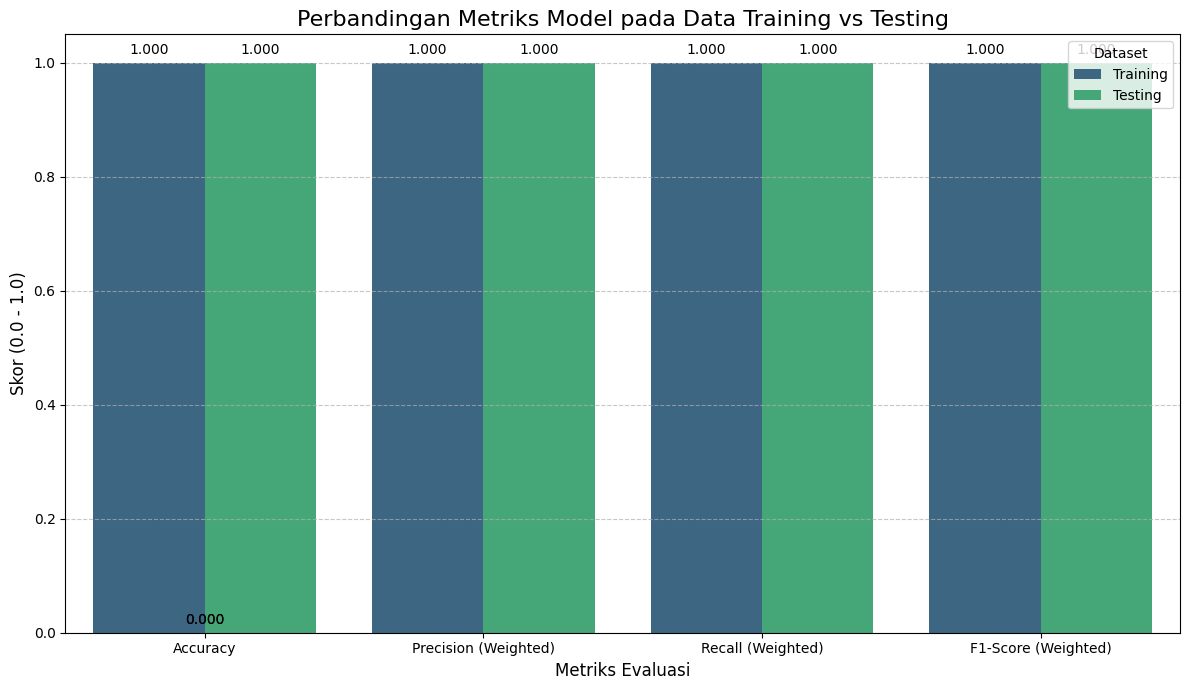

In [ ]:
# === Import library yang diperlukan ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

# === 5. Evaluasi Model ===
# Asumsi variabel 'grid', 'X_train_scaled', 'y_train', 'X_test_scaled', 'y_test',
# dan 'le' (LabelEncoder) sudah ada dari eksekusi blok sebelumnya.

print("Mengevaluasi model terbaik (SVM RBF) pada data Training dan Testing...")

# --- 1. Evaluasi pada Data Training ---
y_pred_train = grid.predict(X_train_scaled)
acc_train = accuracy_score(y_train, y_pred_train)
# Dapatkan laporan klasifikasi lengkap
report_train_dict = classification_report(y_train, y_pred_train, target_names=le.classes_, output_dict=True, zero_division=0)

# Ambil metriks 'weighted avg' untuk perbandingan yang adil (jika data imbalanced)
train_metrics = report_train_dict['weighted avg']
train_precision = train_metrics['precision']
train_recall = train_metrics['recall']
train_f1 = train_metrics['f1-score']

print("\n--- Hasil pada Data Training ---")
print(f"Akurasi: {acc_train:.4f}")
print(f"Precision (Weighted): {train_precision:.4f}")
print(f"Recall (Weighted): {train_recall:.4f}")
print(f"F1-Score (Weighted): {train_f1:.4f}")
# print("\nLaporan Klasifikasi Lengkap (Training):")
# print(classification_report(y_train, y_pred_train, target_names=le.classes_, zero_division=0))


# --- 2. Evaluasi pada Data Testing ---
# (Ini sudah dihitung di blok sebelumnya, tapi kita hitung ulang agar terstruktur)
y_pred_test = grid.predict(X_test_scaled)
acc_test = accuracy_score(y_test, y_pred_test)
# Dapatkan laporan klasifikasi lengkap
report_test_dict = classification_report(y_test, y_pred_test, target_names=le.classes_, output_dict=True, zero_division=0)

# Ambil metriks 'weighted avg'
test_metrics = report_test_dict['weighted avg']
test_precision = test_metrics['precision']
test_recall = test_metrics['recall']
test_f1 = test_metrics['f1-score']

print("\n--- Hasil pada Data Testing ---")
print(f"Akurasi: {acc_test:.4f}")
print(f"Precision (Weighted): {test_precision:.4f}")
print(f"Recall (Weighted): {test_recall:.4f}")
print(f"F1-Score (Weighted): {test_f1:.4f}")
print("\nLaporan Klasifikasi Lengkap (Testing):")
print(classification_report(y_test, y_pred_test, target_names=le.classes_, zero_division=0))


# --- 3. Sajikan Hasil Performa Menggunakan Grafik ---

# Siapkan data untuk DataFrame
data = {
    'Metriks': ['Accuracy', 'Precision (Weighted)', 'Recall (Weighted)', 'F1-Score (Weighted)'],
    'Training': [acc_train, train_precision, train_recall, train_f1],
    'Testing': [acc_test, test_precision, test_recall, test_f1]
}
metrics_df = pd.DataFrame(data)

# 'Melt' dataframe agar mudah di-plot dengan seaborn/matplotlib
metrics_df_melted = metrics_df.melt('Metriks', var_name='Dataset', value_name='Skor')

print("\n--- Ringkasan Performa ---")
display(metrics_df.set_index('Metriks'))

# Buat bar chart
plt.figure(figsize=(12, 7))
ax = sns.barplot(
    x='Metriks',
    y='Skor',
    hue='Dataset',
    data=metrics_df_melted,
    palette='viridis'
)

plt.title('Perbandingan Metriks Model pada Data Training vs Testing', fontsize=16)
plt.ylabel('Skor (0.0 - 1.0)', fontsize=12)
plt.xlabel('Metriks Evaluasi', fontsize=12)
plt.ylim(0, 1.05) # Beri sedikit ruang di atas
plt.legend(title='Dataset', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tambahkan label angka di atas setiap bar
for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.3f}',  # Format angka
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 9),
        textcoords='offset points',
        fontsize=10
    )

plt.tight_layout()
plt.show()